# Baseline Resitive Crack Initial Modeling
---

### Introduction


In [1]:
# %load_ext autoreload
# %autoreload 2
import os
import sys
import copy
import time
import tabulate
import numpy as np
sys.path.append(os.path.join(os.path.abspath(""), ".."))
from app.models import Classifier
from app.utils import ImageWrapper 
from app.transforms import FFT, IFFT, CreateOnesMask, PCA
from app.filters import CreateKernel, Convolve, Canny, HOG
from app.imager import ImageLoader, DefectViewer, Show, Exposure
from app.custom import RemoveBusBars, Orient, HighlightFrontGrid
seed = 1234

from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier

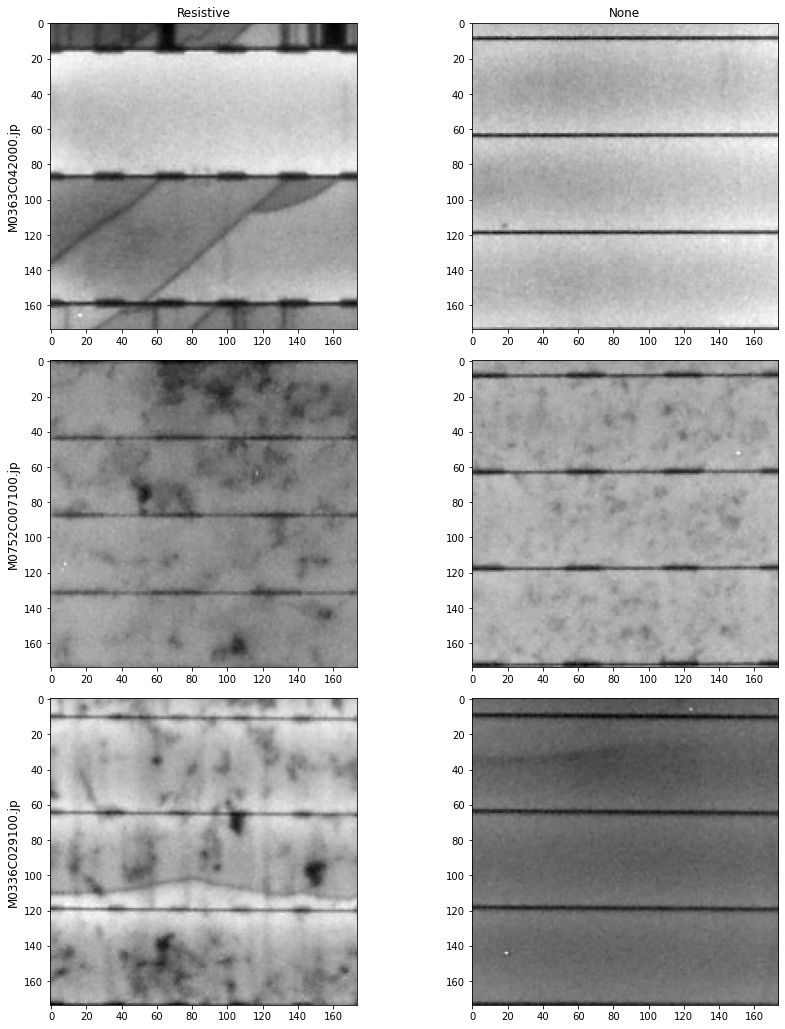

In [2]:
# Load 10 examples and name the category for it. Category is like a title for images
n_samples = 500
defect = (DefectViewer(row_chop=25, col_chop=25) << (ImageLoader(defect_class='Resistive') << n_samples))
defect.category = 'Resistive'
clean = (DefectViewer(row_chop=25, col_chop=25) << (ImageLoader(defect_class='None') << n_samples))
clean.category = 'None'

# View both the defect and the clean class
# I am using a tuple in this case as defect and clean are ImageWrapper objects
# Show random 5 out of the 10 images. Using the seed will ensure the same 5 are shown everytime
_ = Show(num_images=3, seed=seed) << (defect, clean)

In [3]:
oriented_defect = Orient(num_jobs=20) << defect
oriented_clean = Orient(num_jobs=20) << clean
# Remove the BusBars
nobus_defect = RemoveBusBars() << oriented_defect
nobus_clean = RemoveBusBars() << oriented_clean

## Linier Regression
---

In [4]:
%%time
# 1. Base model on raw data
model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': 100}
cla = Classifier(defect, clean, LogisticRegression, None)
score = cla.fit(**model_params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

0.6934683753617197
          Pred 0    Pred 1
------  --------  --------
True 0        63        19
True 1        45        73
CPU times: user 2.4 s, sys: 366 ms, total: 2.77 s
Wall time: 610 ms


In [5]:
%%time
# 2. HOG on RAW data
model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': 100, 'num_jobs': 20}
cla = Classifier(defect, clean, LogisticRegression, HOG)
score = cla.fit(**model_params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

0.7559942124844977
          Pred 0    Pred 1
------  --------  --------
True 0        67        15
True 1        36        82
CPU times: user 2.65 s, sys: 841 ms, total: 3.49 s
Wall time: 4.64 s


In [14]:
# 3. Base model on Busbarless Data
model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': 100}
cla = Classifier(nobus_defect[-1], nobus_clean[-1], LogisticRegression, None)
score = cla.fit(**model_params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

0.718685407193055
          Pred 0    Pred 1
------  --------  --------
True 0        72        10
True 1        52        66


/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [15]:
%%time
# 2. HOG on busbarless
model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': 100, 'num_jobs': 20}
cla = Classifier(nobus_defect[-1], nobus_clean[-1], LogisticRegression, HOG)
score = cla.fit(**model_params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

0.7756304257957833
          Pred 0    Pred 1
------  --------  --------
True 0        73         9
True 1        40        78
CPU times: user 2.76 s, sys: 843 ms, total: 3.6 s
Wall time: 4.72 s


In [5]:
%%time
#3. HOG on Gaussian Filtered Images

# Get hog of clean image
hog_clean = (HOG() <<  clean)

#og images
og = ~(hog_clean[0])

# pull hog images
hog_clean = ~(hog_clean[1])

# Get gaussian of clean image
gaus_clean = ~((Convolve() << (CreateKernel(dim=2, kernel='gaussian', size=45, std=8) << clean))[1])

# superimpose
clean_result = hog_clean + gaus_clean

# get hog of defect
hog_defect = ~((HOG() <<  defect)[1])

# get gaussian of defect
gaus_defect = ~((Convolve() << (CreateKernel(dim=2, kernel='gaussian', size=45, std=8) << defect))[1])

# superimpose
defect_result = hog_defect + gaus_defect

# Convert back to ImageWrapper
iw_clean = ImageWrapper(clean_result, image_labels=['clean'], category=None)
iw_defect = ImageWrapper(defect_result, image_labels=['Resistive'], category='Resistive')

#Instantiate model
model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': 100}
cla = Classifier(iw_defect, iw_clean, LogisticRegression, None)
score = cla.fit(**model_params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))


1.0
          Pred 0    Pred 1
------  --------  --------
True 0        82         0
True 1         0       118
CPU times: user 1min 57s, sys: 616 ms, total: 1min 57s
Wall time: 1min 55s


In [13]:
import matplotlib.pyplot as plt 

In [26]:
y = defect[-1]
plt.figure()
plt.imshow(y, cmap='gray', vmin=0, vmax=1)
plt.show()

TypeError: 'ImageWrapper' object is not subscriptable

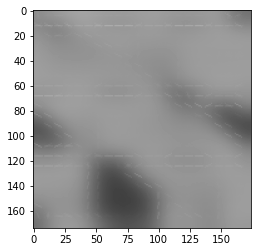

In [20]:

x=hog_defect[0] + gaus_defect[0]

plt.figure()
plt.imshow(x, cmap='gray', vmin=0, vmax=1)
plt.show()

## KMeans Clustering
---

In [50]:
%%time
# 1. Base model on raw data
scr = 0.0
n = 0
for i in range(2,799,1):
    model_params = {'n_clusters': i, 'seed': 14376, 'pca_dims': 100}
    cla = Classifier(defect, clean, KMeans, None)
    score = cla.fit(**model_params)
    if score > scr:
        scr = score
        n = i
print(i, ' : ', score)
        

# Misclassified
# conf, out = cla.misclassified()
# print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: 

/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: 

/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: 

/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: 

/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: 

/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: 

/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: 

/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: 

/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: 

/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: 

/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: 

/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: 

/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: 

/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: 

/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: 

/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: 

/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: 

/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: 

/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: 

/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: 

/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/Documents/git/w281_finalproject_solascan/notebooks/../app/models.py:186: ConvergenceWarning: Number of distinct clusters (763) found smaller than n_clusters (764). Possibly due to duplicate points in X.
  self.model.fit(x_train, y_train)
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/Documents/git/w281_finalproject_solascan/notebooks/../app/models.py:186: ConvergenceWarning: Number of distinct clusters (763) found smaller than n_clusters (765). Possibly due to duplicate points in X.
  self.model.fit(x_train, y_train)
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packa

/home/dan/Documents/git/w281_finalproject_solascan/notebooks/../app/models.py:186: ConvergenceWarning: Number of distinct clusters (766) found smaller than n_clusters (782). Possibly due to duplicate points in X.
  self.model.fit(x_train, y_train)
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/Documents/git/w281_finalproject_solascan/notebooks/../app/models.py:186: ConvergenceWarning: Number of distinct clusters (765) found smaller than n_clusters (783). Possibly due to duplicate points in X.
  self.model.fit(x_train, y_train)
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/dan/Documents/git/w281_finalproject_solascan/notebooks/../ap

798  :  0.00423728813559322
CPU times: user 55min 12s, sys: 4min 17s, total: 59min 29s
Wall time: 20min 52s


/home/dan/Documents/git/w281_finalproject_solascan/notebooks/../app/models.py:186: ConvergenceWarning: Number of distinct clusters (764) found smaller than n_clusters (798). Possibly due to duplicate points in X.
  self.model.fit(x_train, y_train)
/home/dan/anaconda3/envs/w281_enviroment/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


## Random Forrest
---